In [1]:
import numpy as np
from FastCCM import CCM
from manifold_learning.utils import utils
from manifold_learning.data.data_loader import get_truncated_lorenz_rand
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from manifold_learning import imd_nd_smap
from sklearn.decomposition import PCA
import importlib
importlib.reload(imd_nd_smap)

importlib.reload(CCM)

<module 'FastCCM.CCM' from '/home/iaroslav/Documents/Python projects/FastCCM/src/FastCCM/CCM.py'>

In [133]:
def generalized_func(sources, weights, noise_std=0.1):
    """
    Generalized function to compute dependent variables based on source variables.

    Parameters:
    - sources: Array of source variables (shape M).
    - weights: Weight matrix defining relationships (shape KxM).
    - noise_std: Standard deviation of Gaussian noise added to the outputs.

    Returns:
    - dependents: Array of dependent variables (shape K).
    - sources: Updated sources with stochastic evolution.
    """
    # Compute dependent variables
    dependents = np.dot(weights, np.sin(sources)) #+ 0.000001 * np.random.uniform(size=len(weights))

    # Update sources stochastically (arbitrary evolution model)
    updated_sources = 0.5 * sources + noise_std * np.random.uniform(size=len(sources))

    return dependents, updated_sources


# Parameters
N_sources = 5   # Number of source variables
N_dependents = 25  # Number of dependent variables
steps = 2000     # Number of simulation steps

# Randomly initialize source variables and weights
sources = np.random.uniform(0, 1, N_sources)  # Initial source variables
weights = np.random.uniform(-2, 2, (N_dependents, N_sources))  # Weight matrix
weights[weights<0] = 0 

# Initialize storage for results
results = np.zeros((steps, N_dependents + N_sources))

# Simulation loop
for i in range(steps):
    dependents, sources = generalized_func(sources, weights)
    results[i, :N_dependents] = dependents  # Store dependent variables
    results[i, N_dependents:] = sources    # Store updated source variables

# Remove the first 10 rows (burn-in)
results = results[10:]


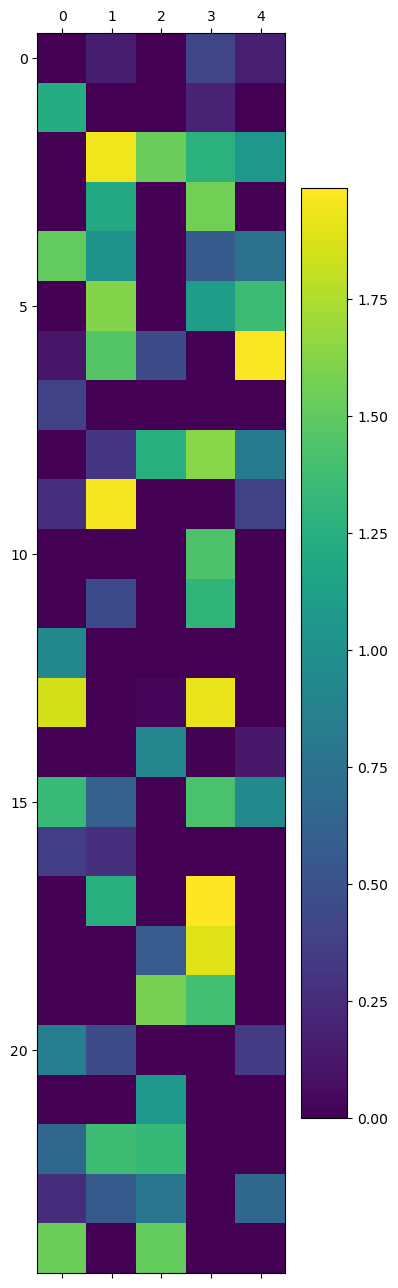

In [134]:
plt.matshow(np.abs(weights))
plt.colorbar()

In [141]:
observables = results[:,:N_dependents]
observables = observables-observables.mean(axis=0)
observables = observables/observables.std(axis=0)
observables = np.concatenate(utils.get_td_embedding_np(observables,5,1).T).T

In [169]:
trainer = imd_nd_smap.IMD_nD_smap(observables.shape[1], embed_dim=3, n_components=3, subtract_corr=False, device="cuda")


In [170]:

trainer.fit(observables, sample_len=50, library_len=300, 
            exclusion_rad=10, theta=5, tp=3, 
            epochs=1000, num_batches=32,optimizer="Adagrad", learning_rate=0.01, tp_policy="range",loss_mask_size=None)
            


Epoch 1/1000, Loss: 0.9074
Epoch 2/1000, Loss: 0.8005
Epoch 3/1000, Loss: 0.6912
Epoch 4/1000, Loss: 0.6271
Epoch 5/1000, Loss: 0.5681
Epoch 6/1000, Loss: 0.4868
Epoch 7/1000, Loss: 0.4644
Epoch 8/1000, Loss: 0.4685
Epoch 9/1000, Loss: 0.4080
Epoch 10/1000, Loss: 0.3700
Epoch 11/1000, Loss: 0.3554
Epoch 12/1000, Loss: 0.3413
Epoch 13/1000, Loss: 0.3003
Epoch 14/1000, Loss: 0.2923
Epoch 15/1000, Loss: 0.2727
Epoch 16/1000, Loss: 0.2622
Epoch 17/1000, Loss: 0.2520
Epoch 18/1000, Loss: 0.2383
Epoch 19/1000, Loss: 0.2269
Epoch 20/1000, Loss: 0.2279
Epoch 21/1000, Loss: 0.2129
Epoch 22/1000, Loss: 0.2049
Epoch 23/1000, Loss: 0.2006
Epoch 24/1000, Loss: 0.1958
Epoch 25/1000, Loss: 0.2123
Epoch 26/1000, Loss: 0.1923
Epoch 27/1000, Loss: 0.1949
Epoch 28/1000, Loss: 0.1831
Epoch 29/1000, Loss: 0.1712
Epoch 30/1000, Loss: 0.1616
Epoch 31/1000, Loss: 0.1634
Epoch 32/1000, Loss: 0.1593
Epoch 33/1000, Loss: 0.1449
Epoch 34/1000, Loss: 0.1416
Epoch 35/1000, Loss: 0.1413
Epoch 36/1000, Loss: 0.1450
E

KeyboardInterrupt: 

In [171]:

unmixed = trainer.predict(observables)

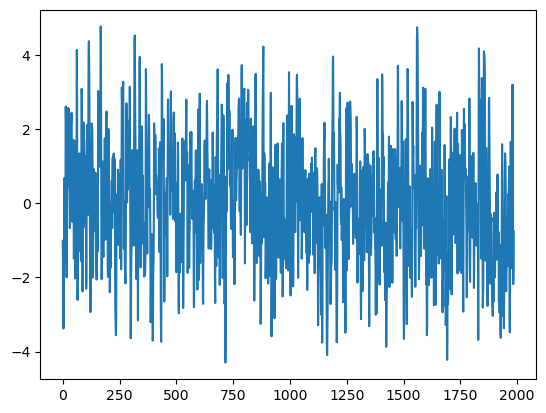

In [172]:
plt.plot(unmixed[:,1,0])

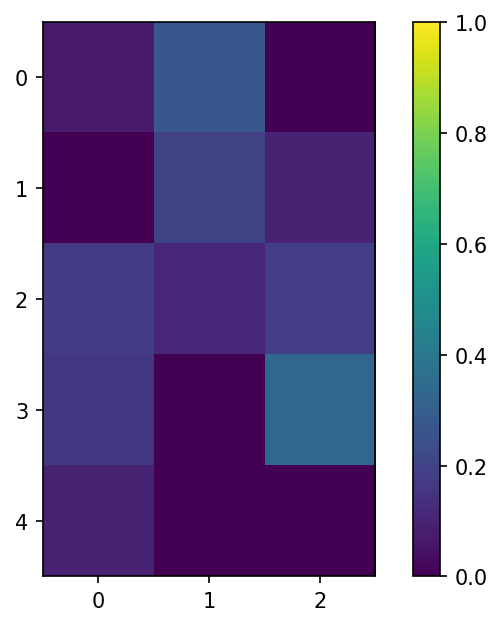

In [173]:
ccm_matrix_unmixed = CCM.PairwiseCCM().compute(
    np.transpose(unmixed, axes=(1, 0, 2)),
    results[:,N_dependents:].T[:,:,None],
    250, 250,3, 0,
    method="smap",
    theta=4,
).mean(axis=0)
plt.figure(dpi=150)
plt.imshow(ccm_matrix_unmixed, vmin=0, vmax=1)
plt.colorbar()
